In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

sys.path.insert(0, "../src/")
sys.path.insert(0, "../../project_1/src")
from NeuralNetwork import *
from CostFunctions import *
from ActivationFunctions import *
from SGD import *
from sklearn.model_selection import train_test_split
from FrankeFunction import *
from linear_regression import *
from stat_tools import *
from analysis_utils import *

## Notes
https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use

- Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that you must apply the same scaling to the test set for meaningful results. You can use StandardScaler for standardization.

Hastie p400
- Generally speaking it is better to have too many hidden units than too few. With too few hidden units, the model might not have enough flexibility to capture the nonlinearities in the data; with too many hidden units, the extra weights can be shrunk toward zero if appropriate regularization is used. Typically the number of hidden units is somewhere in the range of 5 to 100, with the number increasing with the number of inputs and number of training cases. It is most common to put down a reasonably large number of units and train them with regularization. Some researchers use cross-validation to estimate the optimal number, but this seems unnecessary if cross-validation is used to estimate the regularization parameter.

- Since the scaling of the inputs determines the effective scaling of the weights in the bottom layer, it can have a large effect on the quality of the final solution. At the outset it is best to standardize all inputs to have mean zero and standard deviation one. This ensures all inputs are treated equally in the regularization process, and allows one to choose a meaningful range for the random starting weights. With standardized inputs, it is typical to take random uniform weights over the range [−0.7, +0.7].

In [2]:
#np.random.seed(2020)
N = 500

xy = np.random.uniform(0, 1, (N, 2))
#resolution = 25
#x = np.linspace(0, 1, resolution)
#y = np.linspace(0, 1, resolution)
#X, Y = np.meshgrid(x, y)
#X_flat, Y_flat = X.flatten(), Y.flatten()
#xy = np.array([X_flat, Y_flat]).T

N = len(xy)
print(N)

z = FrankeFunction(xy[:, 0], xy[:, 1]) +  np.random.normal(0, 1, N) * 0.2
z = z.reshape(-1,1)

xy_train, xy_test, z_train, z_test = train_test_split(xy, z, test_size=0.2)

# Rescale & center data wrt. training data
#z_train_intercept = np.mean(z_train)
#z_train -= z_train_intercept
#z_test -= z_train_intercept

#scaler = StandardScaler()
#scaler.fit(xy_train)
#xy_train = scaler.transform(xy_train)
#xy_test = scaler.transform(xy_test)

500


### NN Notes
- 30 hidden layers -> ~0.06 MSE. Learning rates => blow up after 1e-3 and penalty has no clear effect
- reducing to 10 layers keeps the same order of MSE + weights explode at learning rate of ~1 instead.
- No clear effect of adding a second layer with 5 nodes.

In [3]:
learning_rates = np.logspace(-3, -1, 3)
penalties = np.logspace(-5, 1, 7)

cv_mse = np.empty([len(learning_rates), len(penalties)])

for i in range(len(learning_rates)):
    for j in range(len(penalties)):
        f = generate_FFNN_score_func(
            N_minibatches = int(N/32),
            learning_rate = learning_rates[i], 
            n_epochs = 1000,
            network_shape=[10, 5],
            activation=ActivationFunctions.Sigmoid,
            activation_out=ActivationFunctions.ID,
            lambd=penalties[j],
            init_weights_method="he")

        cv_mse[i, j] = CrossValidation(xy, z, f, 5)

Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initiali

../src/NeuralNetwork.py:211: RuntimeWarning: overflow encountered in matmul
  self.z[-1] = self.a[-2] @ self.weights[-1].T + self.biases[-1]
../src/NeuralNetwork.py:232: RuntimeWarning: invalid value encountered in matmul
  self.error[l + 1] @ self.weights[l + 1]
../src/NeuralNetwork.py:235: RuntimeWarning: invalid value encountered in matmul
  self.cost_weight_gradient[0] = self.error[0].T @ X_mb
../src/NeuralNetwork.py:240: RuntimeWarning: invalid value encountered in matmul
  self.cost_weight_gradient[l] = self.error[l].T @ self.a[l - 1]
../src/NeuralNetwork.py:206: RuntimeWarning: invalid value encountered in matmul
  self.z[l] = self.a[l - 1] @ self.weights[l].T + self.biases[l]
../src/NeuralNetwork.py:289: RuntimeWarning: invalid value encountered in multiply
  self.weights[l] * self.momentum
../src/NeuralNetwork.py:294: RuntimeWarning: invalid value encountered in multiply
  self.biases[l] * self.momentum


Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He
Initializing weights using: He


In [4]:
print(cv_mse)
#print(np.amin(cv_mse))

[[0.06397148 0.06400914 0.06458537 0.06384451 0.06409665 0.06804814
  0.11933952]
 [0.06357515 0.06349324 0.06402913 0.0639108  0.0640645  0.11887875
  0.11929304]
 [0.06440809 0.06427827 0.06495322        nan 0.06555411 0.11943808
  0.1192024 ]]


In [5]:
per_loop = 1
tot_epochs = 150
num_loops = int(tot_epochs / per_loop)

NN_MSE = np.empty(num_loops)
NN_epochs = np.empty(num_loops)

FFNN = FeedForwardNeuralNetwork(
    X=xy_train,
    Y=z_train,
    cost=CostFunctions.SquareError,
    activation=ActivationFunctions.ELU,
    activation_out=ActivationFunctions.ID,
    network_shape=[30]
)

for i in range(num_loops):
    FFNN.train(N_minibatches=int(N/32), learning_rate=0.01, n_epochs=per_loop)
    NN_MSE[i] = MSE(z_test, FFNN.predict(xy_test))
    NN_epochs[i] = FFNN.total_epochs

Initializing weights using: Normal distribution


In [6]:
skl_model = MLPRegressor(
    hidden_layer_sizes = [30],
    activation = 'relu',
    solver = 'sgd',
    batch_size = 32,
    learning_rate_init = 0.1,
    max_iter = 1_000,
    tol=1e-6,
    momentum = 0,
    early_stopping = False,
    alpha = 0
)
skl_model.fit(xy_train, z_train.flatten())

MLPRegressor(alpha=0, batch_size=32, hidden_layer_sizes=[30],
             learning_rate_init=0.1, max_iter=1000, momentum=0, solver='sgd',
             tol=1e-06)

In [7]:
print("Outgoing activation: ",skl_model.out_activation_)
print("No. Itterations: ", skl_model.n_iter_)

Outgoing activation:  identity
No. Itterations:  95


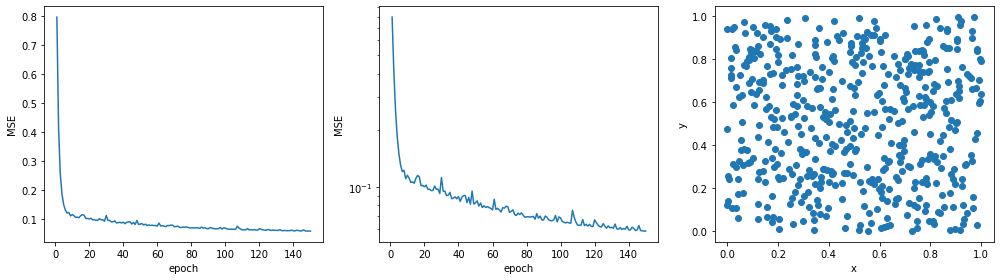

In [8]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(NN_epochs, NN_MSE)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.subplot(132)
plt.semilogy(NN_epochs, NN_MSE)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.subplot(133)
plt.scatter(xy[:, 0], xy[:, 1])
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

In [9]:
FFNN.train(N_minibatches=int(500/32), learning_rate=0.01, n_epochs=per_loop)
print(FFNN.total_epochs)# Predict using our class
resolution = 100
x = np.linspace(0, 1, resolution)
y = np.linspace(0, 1, resolution)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
XY_flat = np.array([X_flat, Y_flat]).T
#XY_flat_scaled = scaler.fit(XY_flat)
Z_pred = FFNN.predict(XY_flat)
Z_pred = Z_pred.T.reshape(X.shape) # + z_train_intercept
Z_Franke = FrankeFunction(X, Y)

151


In [10]:
# Predict using Scikit
z_skl_pred = skl_model.predict(XY_flat)
z_skl_pred = z_skl_pred.T.reshape(X.shape)

In [11]:
resolution = 100
x = np.linspace(0, 1, resolution)
y = np.linspace(0, 1, resolution)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
XY_flat = np.array([X_flat, Y_flat]).T
#XY_flat_scaled = scaler.fit(XY_flat)
Z_pred = FFNN.predict(XY_flat)
Z_pred = Z_pred.T.reshape(X.shape) # + z_train_intercept
Z_Franke = FrankeFunction(X, Y)

151


Text(0.5, 0.92, 'SKLearn')

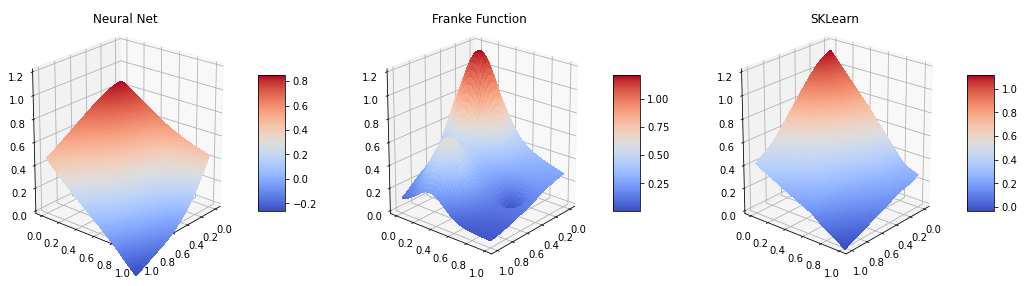

In [12]:
#FFNN.train(N_minibatches=int(N/32), learning_rate=0.1, n_epochs=5_000)
print(FFNN.total_epochs)# Predict using our class

elev = 20
azim = 40

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(1, 3, 1, projection="3d")
surf = ax.plot_surface(X, Y, Z_pred, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(elev=elev, azim=azim)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim([0, 1.2])
ax.set_title("Neural Net")

ax = fig.add_subplot(1, 3, 2, projection="3d")
surf = ax.plot_surface(X, Y, Z_Franke, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(elev=elev, azim=azim)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim([0, 1.2])
ax.set_title("Franke Function")

ax = fig.add_subplot(1, 3, 3, projection="3d")
surf = ax.plot_surface(X, Y, z_skl_pred, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(elev=elev, azim=azim)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim([0, 1.2])
ax.set_title("SKLearn")

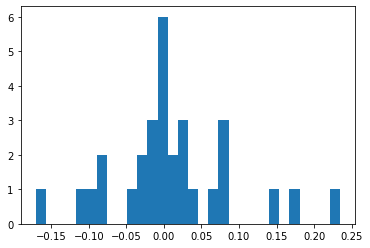

In [13]:
plt.hist(FFNN.biases[0], bins=30)
plt.show()